https://arxiv.org/abs/1801.04381

### MobileNet V2

#### Inverted Residual block(bottleneck block)
MobileNet V1で扱ったDepthwise Separable Convolutionsにbottleneck構造を持たせます。  
図の(d)のように3×3のdepthwise convolutionをpointwise convolutionで挟み込んだ構造となります。
1つ目のpointwise convでチャンネル数を増加させ、2つ目のpointwise convでチャンネル数を減少させます。

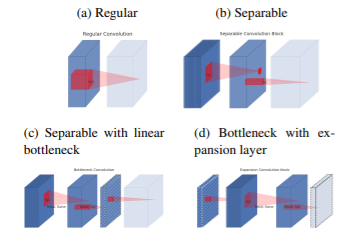

さらに下の図の右側のようにResidual接続を持たせます。

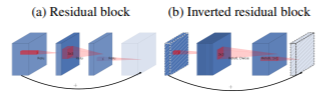

このbottleneckの構造を詳しく見ます。

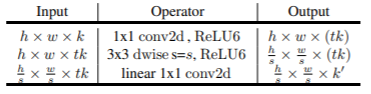

$k$は入力、$k'$は出力のチャンネル数、$t$はチャンネル数の倍率、$s$はストライドを表します。
非線形関数としてReLU6が使用されています。これは出力の最大値を6としてクリップする関数となります。

次にMobileNet V2の構造を確認します。$n$はブロックの繰り返し数となります。
複数回繰り返す場合は、最初のブロックでチャンネル数が拡張、strideが2の場合も最初のブロックのみ適用となります。
bottleneckのresiduak接続は入力と出力の形式が同じときのみ適用とします。

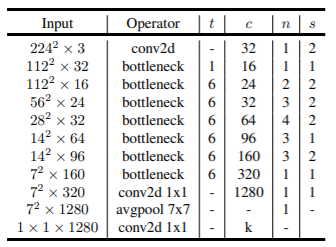

#### 学習
最適化手法はRMSpropを使用しdecayとmomentumは0.9とします。そしてweight decayは0.00004です。学習率は初期値を0.045としてエポックごとに減衰率0.98で減衰させていきます。

In [11]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Add
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import cv2

In [22]:
class Inverted_Residual_block(Model):
    def __init__(self, in_channels, out_channels, s, t):
        super().__init__()
        k = in_channels
        self.conv1 = Conv2D(filters = t*k, kernel_size = (1,1), padding = 'same')
        self.bn1 = BatchNormalization()
        self.relu1 = tf.nn.relu6
    
        self.conv2 = DepthwiseConv2D(kernel_size = (3,3), strides=s, padding = 'same')
        self.bn2 = BatchNormalization()
        self.relu2 = tf.nn.relu6

        self.conv3 = Conv2D(filters = out_channels, kernel_size = (1,1), padding = 'same')
        self.bn3 = BatchNormalization()
        self.relu3 = tf.nn.relu6
        
        self.add = Add()
    
    def call(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        
        if K.int_shape(out) == K.int_shape(x):
            out = self.add([out, x])
        
        return out

In [57]:
class bottleneck(Model):
    def __init__(self, in_channels, t, c, n, s):
        super().__init__()
        S = np.ones(n)
        S[0] = s
        self.bottleneck = Sequential([Inverted_Residual_block(in_channels=in_channels, out_channels=c, s=int(S[i]), t=t) for i in range(n)])
    
    def call(self, x):
        x = self.bottleneck(x)
        return x

In [58]:
class MobileNetV2(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, kernel_size=3, strides=2, padding="same")
        self.bn1 = BatchNormalization()
        self.relu1 = tf.nn.relu6
        
        self.bottleneck1 = bottleneck(in_channels=32,  t=1, c=16,  n=1, s=1)
        self.bottleneck2 = bottleneck(in_channels=16,  t=6, c=24,  n=2, s=2)
        self.bottleneck3 = bottleneck(in_channels=24,  t=6, c=32,  n=3, s=2)
        self.bottleneck4 = bottleneck(in_channels=32,  t=6, c=64,  n=4, s=2)
        self.bottleneck5 = bottleneck(in_channels=64,  t=6, c=96,  n=3, s=1)
        self.bottleneck6 = bottleneck(in_channels=96,  t=6, c=160, n=3, s=2)
        self.bottleneck7 = bottleneck(in_channels=160, t=6, c=320, n=1, s=1)
        self.conv2 = Conv2D(1280, kernel_size=1, strides=1, padding="same")
        self.bn2 = BatchNormalization()
        self.relu2 = tf.nn.relu6
        
        self.pool = GlobalAveragePooling2D()
        self.fc = Dense(10, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)
        x = self.bottleneck4(x)
        x = self.bottleneck5(x)
        x = self.bottleneck6(x)
        x = self.bottleneck7(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.fc(x)
        return x

In [59]:
model = MobileNetV2()
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization_215 (Bat (None, 112, 112, 32)      128       
_________________________________________________________________
tf_op_layer_Relu6_5 (TensorF [(None, 112, 112, 32)]    0         
_________________________________________________________________
bottleneck_32 (bottleneck)   (None, 112, 112, 16)      2224      
_________________________________________________________________
bottleneck_33 (bottleneck)   (None, 56, 56, 24)        12336     
_________________________________________________________________
bottleneck_34 (bottleneck)   (None, 28, 28, 32)      

In [ ]:
epochs = 100
initial_lrate = 0.045

def decay(epoch, steps=100):
    initial_lrate = 0.045
    drop = 0.98
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=initial_lrate, rho=0.9, epsilon=1.0, decay=0.9)

lr_sc = LearningRateScheduler(decay, verbose=1)

model = MobileNetV2()
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [87]:
from keras.applications.mobilenet_v2 import MobileNetV2

input_shape = (224,224,3)
num_classes = 10

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[:17]:
    layer.trainable = False

9412608/9406464 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 0us/step


In [88]:
epochs = 100
initial_lrate = 0.045

def decay(epoch, steps=100):
    initial_lrate = 0.045
    drop = 0.98
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=initial_lrate, rho=0.9, epsilon=1.0, decay=0.9)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

14540800/14536120 [==============================] - ETA: 1: - ETA: 2s - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 0us/step


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [63]:
class Depthwise_Separable_convolutions(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv_dw = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size = (3,3), stride=stride, groups=in_channels, padding = 1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=False)
        
        self.conv_pw = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = (1,1), padding = 'same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=False)
    
    def forward(self, x):
        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [70]:
class Inverted_Residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, s, t):
        super().__init__()
        k = in_channels
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=t*k, kernel_size = (1,1))
        self.bn1 = nn.BatchNorm2d(t*k)
        self.relu1 = F.relu6
    
        self.conv2 = Depthwise_Separable_convolutions(in_channels=t*k, out_channels=out_channels, stride=s)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = F.relu6

        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size = (1,1))
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = F.relu6
        
        self._change = (in_channels==out_channels)&(s==1)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        
        if self._change:
            out = out + x
        
        return out

In [79]:
class bottleneck(nn.Module):
    def __init__(self, in_channels, t, c, n, s):
        super().__init__()
        S = np.ones(n)
        S[0] = s
        
        IN = np.ones(n)*c
        IN[0] = in_channels
        
        self.bottleneck = nn.Sequential(*[Inverted_Residual_block(in_channels=int(IN[i]), out_channels=c, s=int(S[i]), t=t) for i in range(n)])
    
    def forward(self, x):
        x = self.bottleneck(x)
        return x

In [85]:
class MobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = F.relu6
        
        self.bottleneck1 = bottleneck(in_channels=32,  t=1, c=16,  n=1, s=1)
        self.bottleneck2 = bottleneck(in_channels=16,  t=6, c=24,  n=2, s=2)
        self.bottleneck3 = bottleneck(in_channels=24,  t=6, c=32,  n=3, s=2)
        self.bottleneck4 = bottleneck(in_channels=32,  t=6, c=64,  n=4, s=2)
        self.bottleneck5 = bottleneck(in_channels=64,  t=6, c=96,  n=3, s=1)
        self.bottleneck6 = bottleneck(in_channels=96,  t=6, c=160, n=3, s=2)
        self.bottleneck7 = bottleneck(in_channels=160, t=6, c=320, n=1, s=1)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(1280)
        self.relu2 = F.relu6
        
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1280,10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)
        x = self.bottleneck4(x)
        x = self.bottleneck5(x)
        x = self.bottleneck6(x)
        x = self.bottleneck7(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [86]:
from torchsummary import summary

summary(MobileNetV2(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 32, 112, 112]           1,056
       BatchNorm2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             320
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 16, 112, 112]             528
       BatchNorm2d-9         [-1, 16, 112, 112]              32
             ReLU-10         [-1, 16, 112, 112]               0
Depthwise_Separable_convolutions-11         [-1, 16, 112, 112]               0
      BatchNorm2d-12         [-1, 16, 112, 112]              32
           Conv2d-13         [-1, 16, 112, 112]             272
      BatchNorm2d-14    

Inverted_Residual_block-122           [-1, 64, 14, 14]               0
          Conv2d-123          [-1, 384, 14, 14]          24,960
     BatchNorm2d-124          [-1, 384, 14, 14]             768
          Conv2d-125          [-1, 384, 14, 14]           3,840
     BatchNorm2d-126          [-1, 384, 14, 14]             768
            ReLU-127          [-1, 384, 14, 14]               0
          Conv2d-128           [-1, 64, 14, 14]          24,640
     BatchNorm2d-129           [-1, 64, 14, 14]             128
            ReLU-130           [-1, 64, 14, 14]               0
Depthwise_Separable_convolutions-131           [-1, 64, 14, 14]               0
     BatchNorm2d-132           [-1, 64, 14, 14]             128
          Conv2d-133           [-1, 64, 14, 14]           4,160
     BatchNorm2d-134           [-1, 64, 14, 14]             128
Inverted_Residual_block-135           [-1, 64, 14, 14]               0
      bottleneck-136           [-1, 64, 14, 14]               0
          

In [ ]:
class MobileNetV2Trainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MobileNetV2()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.parameters(), lr=0.045, eps=1.0, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.02)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [92]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model

Using cache found in C:\Users\tanak/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [91]:
from torchvision.models import mobilenetv2
Model = mobilenetv2.mobilenet_v2(pretrained=True)
Model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [ ]:
class MobileNetV2Trainer(pl.LightningModule):
    def __init__(self):
        super(VGGTrainer, self).__init__()
        model = mobilenetv2.mobilenet_v2(pretrained=True)
        
        model.classifier[1] = nn.Linear(in_features=1280, out_features=10)
        self.model = model
        
        update_param_names = ['classifier.1.weight', 'classifier.1.bias']
        
        for name, param in self.model.named_parameters():
            if name in update_param_names:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        #return [optimizer,], [scheduler,]
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}